In [1]:
from quantum_logical.error_channel import (
    AmplitudeDamping,
    PhaseDamping,
    MultiQubitErrorChannel,
)
import numpy as np
import matplotlib.pyplot as plt
from qutip.metrics import fidelity
from qutip.operators import sigmax, sigmay, sigmaz
from qutip import basis
from qutip import expect
from quantum_logical.error_channel import ErrorChannel
from qutip import qeye, tensor
import qutip
from tqdm import tqdm

In [2]:
# Define the number of qubits
N = 4  # Number of qubits
delays = np.linspace(0, 25, 40)  # Sweeping delay from 0 to 10

# Initialize T1 and T2 times for each qubit
T1s = [1] * N
T2s = [1] * N  # Assuming all qubits have the same T2 time
trotter_step_size = 0.2

# Create initial states for a N-qubit system
zero_rho = basis(2, 0) * basis(2, 0).dag()  # |0><0| state for a single qubit
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1| state for a single qubit

# Define the N-qubit initial state |11...1> (N ones)
initial_state = tensor([one_rho] * N)
initial_state /= initial_state.norm()

# Define a N-qubit GHZ state (density matrix)
ghz_state = tensor([one_rho] * N) + tensor([zero_rho] * N)
ghz_state /= ghz_state.norm()

In [3]:
# Define the observables for the N-qubit system and create a dictionary to hold the observables with their labels
def define_observables(N):
    observable_labels = []
    observables = {}

    # Start with all Zs and successively replace one Z with I from right to left
    for num_z in range(N, -1, -1):  # Start with N Z's, down to 0 Z's
        label = "".join(["Z" if i < num_z else "I" for i in range(N)])
        observable_labels.append(label)
        observables[label] = tensor(
            *([sigmaz() if i < num_z else qeye(2) for i in range(N)])
        )

    return observables, observable_labels


def multi_qubit_experiment(rho_initial, delay, trotter_step_size, T1s, T2s):
    error_channel = MultiQubitErrorChannel(N, T1s, T2s, trotter_step_size)
    rho_final = error_channel.apply_error_channel(rho_initial, delay)
    fid = fidelity(rho_initial, rho_final)
    return rho_final, fid

In [4]:
def plot_observable_decay(
    state, observables, observable_labels, delays, trotter_step_size, T1s, T2s
):
    plt.figure(figsize=(4, 4))

    # Precompute the final states for each delay
    final_states = []
    for delay in tqdm(delays):
        rho_final, _ = multi_qubit_experiment(state, delay, trotter_step_size, T1s, T2s)
        final_states.append(rho_final)

    # Calculate and plot expectation values for each observable
    for label in observable_labels:
        obs = observables[label]
        exp_values = [expect(obs, rho_final) for rho_final in final_states]
        plt.plot(delays, exp_values, "-.", label=label)

    plt.legend()
    plt.xlabel("Delay")
    plt.ylabel("Expectation Value")
    plt.title("Observable Expectation Values Over Time")
    plt.show()

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:01<00:00, 23.34it/s]


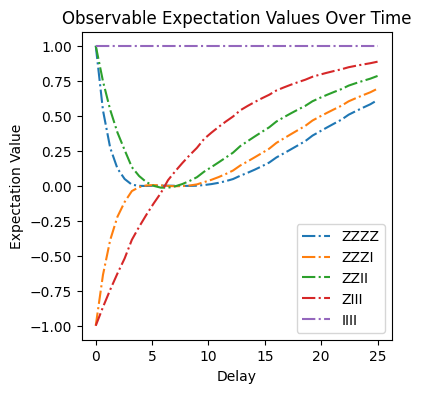

In [5]:
# Generate the observables and their labels
observables, observable_labels = define_observables(N)

# Now call the updated function with labels
plot_observable_decay(
    initial_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
    T1s,
    T2s,
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:01<00:00, 25.67it/s]


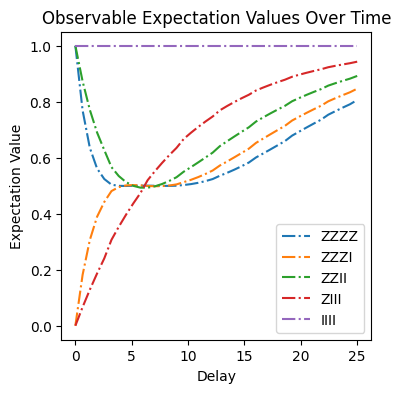

In [6]:
# Now call the updated function with labels
plot_observable_decay(
    ghz_state,
    observables,
    observable_labels,
    delays,
    trotter_step_size,
    T1s,
    T2s,
)

In [7]:
# import cProfile

# # Profile the function and save the stats to a file
# cProfile.run(
#     "plot_observable_decay(ghz_state,observables,observable_labels,delays,trotter_step_size,T1s,T2s,)",
#     "profile_output.prof",
# )